# Gash canopy interception

## Introduction

A modified Gash method has been used in the Hawaii Water Budget model, and that method has now been incorporated into SWB. The parameterization for the modified Gash method could be done via tables, but for now the Gash parameters are read in as gridded datasets. In this example, the canopy cover, stemflow fraction, and evaporation to rainfall ratio grids were created by rasterizing an existing shapefile; this shapefile was initially developed for use with the Hawai'i Water Budget Code.

The grids were created with the gdal utilities as follows:

#### Canopy Cover ####
~~~~~~
gdal_rasterize -a canopy_cov -of GTiff -te 732530. 2272800. 820280. 2329800. -tr 25. 25. -ot Float32 Maui_test_polygon_input_AWC_HSG_v2.shp maui_canopy_cover_fraction.tif

gdal_translate -ot Float32 -of AAIGrid -a_nodata -999.0 -co "DECIMAL_PRECISION=3" maui_canopy_cover_fraction.tif maui_canopy_cover_fraction.asc
~~~~~~

#### Stemflow Fraction ####
~~~~~~
gdal_rasterize -a stemflow -of GTiff -te 732530. 2272800. 820280. 2329800. -tr 25. 25. -ot Float32 Maui_test_polygon_input_AWC_HSG_v2.shp maui_stemflow_fraction.tif

gdal_translate -ot Float32 -of AAIGrid -a_nodata -999.0 -co "DECIMAL_PRECISION=3" maui_stemflow_fraction.tif maui_stemflow_fraction.asc
~~~~~~

#### Evaporation to Rainfall Ratio ####
~~~~~~
gdal_rasterize -a EdivR -of GTiff -te 732530. 2272800. 820280. 2329800. -tr 25. 25. -ot Float32 Maui_test_polygon_input_AWC_HSG_v2.shp maui_evaporation_to_rainfall_ratio.tif

gdal_translate -ot Float32 -of AAIGrid -a_nodata -999.0 -co "DECIMAL_PRECISION=3" maui_evaporation_to_rainfall_ratio.tif maui_evaporation_to_rainfall_ratio.asc
~~~~~~

In order to reduce the size of the example files, the 25 m grids were resampled to a 50 m resolution.

## Gash Interception Theory (brief)

The Gash method as implemented in SWB partitions intercepted water into two components: canopy storage, and trunk storage. The fraction characterized as canopy storage is assumed to evaporate within the same day as the rainfall that generated it. A portion of rainfall is assumed to be diverted to the tree trunk in the form of stemflow.

The first step in the application of the Gash method is to establish the amount of rainfall required to completely saturate the canopy:

$P_{sat} = - \frac{S}{c \cdot V}\ln(1-V)$

where:

$P_{sat}$ = precipitation necessary to saturate the canopy (inches),

$S$ = canopy storage capacity (inches),

$c$ = canopy cover as a fraction of cell area (dimensionless),

$V$ = ratio of mean evaporation rate to the mean precipitation rate during saturated conditions (dimensionless).

Once $P_{sat}$ has been determined, the daily rainfall $P_i$ falls into one of the three conditions shown below, which determines the formulation applied to calculate interception.


| Rainfall condition       | Gash interception equation terms                               |
|--------------------------|----------------------------------------------------------------|
| $P_i < P_{sat}$          | $I = c \cdot P_i$ |
| $P_i \geq P_{sat}$ and $P_i \leq \frac{k}{p}$ | $I = c \cdot P_{sat} + c \cdot V \cdot (P_i - P_{sat}) + p \cdot P_i$ |
| $P_i \geq P_{sat}$ and $P_i > \frac{k}{p}$ | $I = c \cdot P_{sat} + c \cdot V \cdot (P_i - P_{sat}) + k$ |

In the equations given above, $k$ is the trunk storage capacity in inches and $p$ is the proportion of rainfall diverted to stemflow (dimensionless).

## Preliminaries

In [2]:
import os
import numpy as np
import pandas as pd
from osgeo import gdal

from plot_and_table_functions import ( read_raster,
                                       make_plot,
                                       make_scatter,
                                       discrete_cmap,
                                       discrete_irreg_cmap,
                                       discrete_random_cmap )
# grid files
canopy_cover_grid_filename           = '../input/maui_PERCENT_CANOPY_COVER__50m.asc'
evap_to_rainfall_grid_filename       = '../input/maui_EVAPORATION_TO_RAINFALL_RATIO__50m.asc'

## Read grids and tables

In [3]:
# read in runoff zone grid
cc_data, cc_gt, cc_proj, cc_xy        = read_raster( canopy_cover_grid_filename )
er_data, er_gt, er_proj, er_xy        = read_raster( evap_to_rainfall_grid_filename )

c:\Users\smwesten\.local\share\mamba\envs\py312\Lib\site-packages\osgeo\gdal.py:606: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(



reading in ../input/maui_PERCENT_CANOPY_COVER__50m.asc into numpy array...
creating a grid of xy coordinates in the original projection...

reading in ../input/maui_EVAPORATION_TO_RAINFALL_RATIO__50m.asc into numpy array...
creating a grid of xy coordinates in the original projection...


## Input datasets and grids

### Canopy Cover Grid

The Gash canopy interception model is geared toward estimating canopy interception for forest vegetation. Interception is modified based on each cells' percent of forest canopy cover. SWB version 2 allows canopy cover to be supplied as a fraction (0.0 to 1.0) or as a percent of total (0% to 100%).

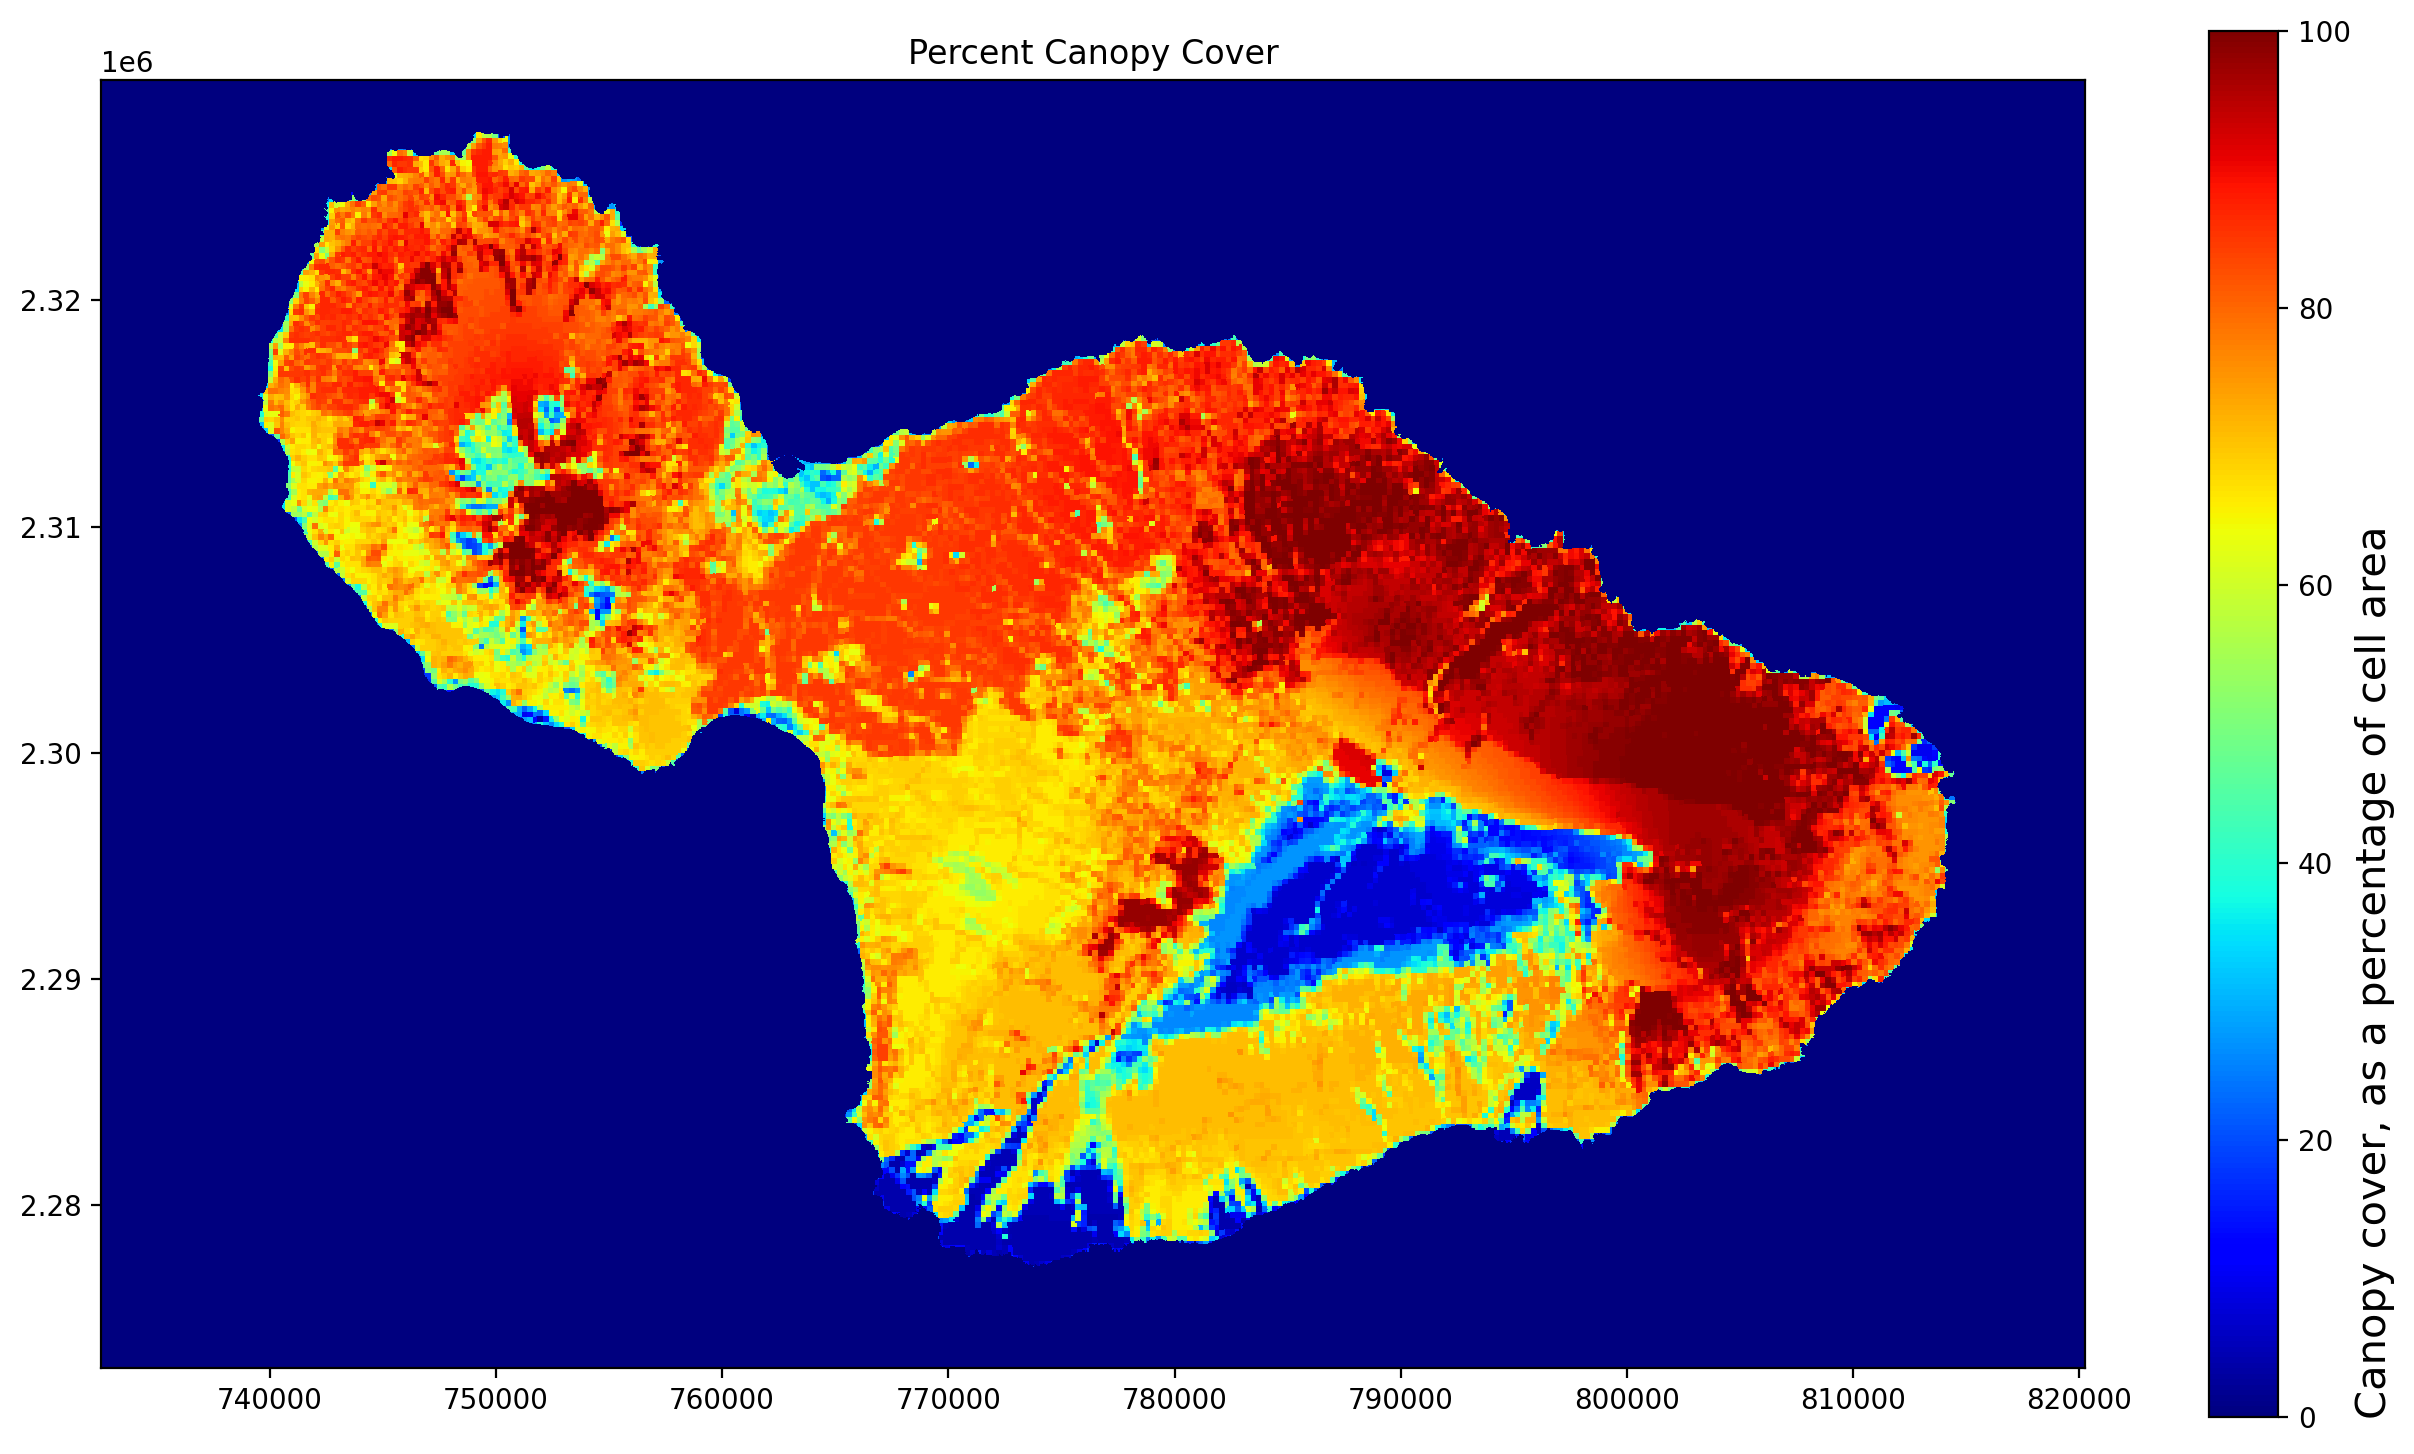

In [4]:
make_plot( x=cc_xy[0], y=cc_xy[1], var=cc_data, discrete=False, title='Percent Canopy Cover',
           barlabel='Canopy cover, as a percentage of cell area')

### Evaporation to Rainfall Ratio Grid

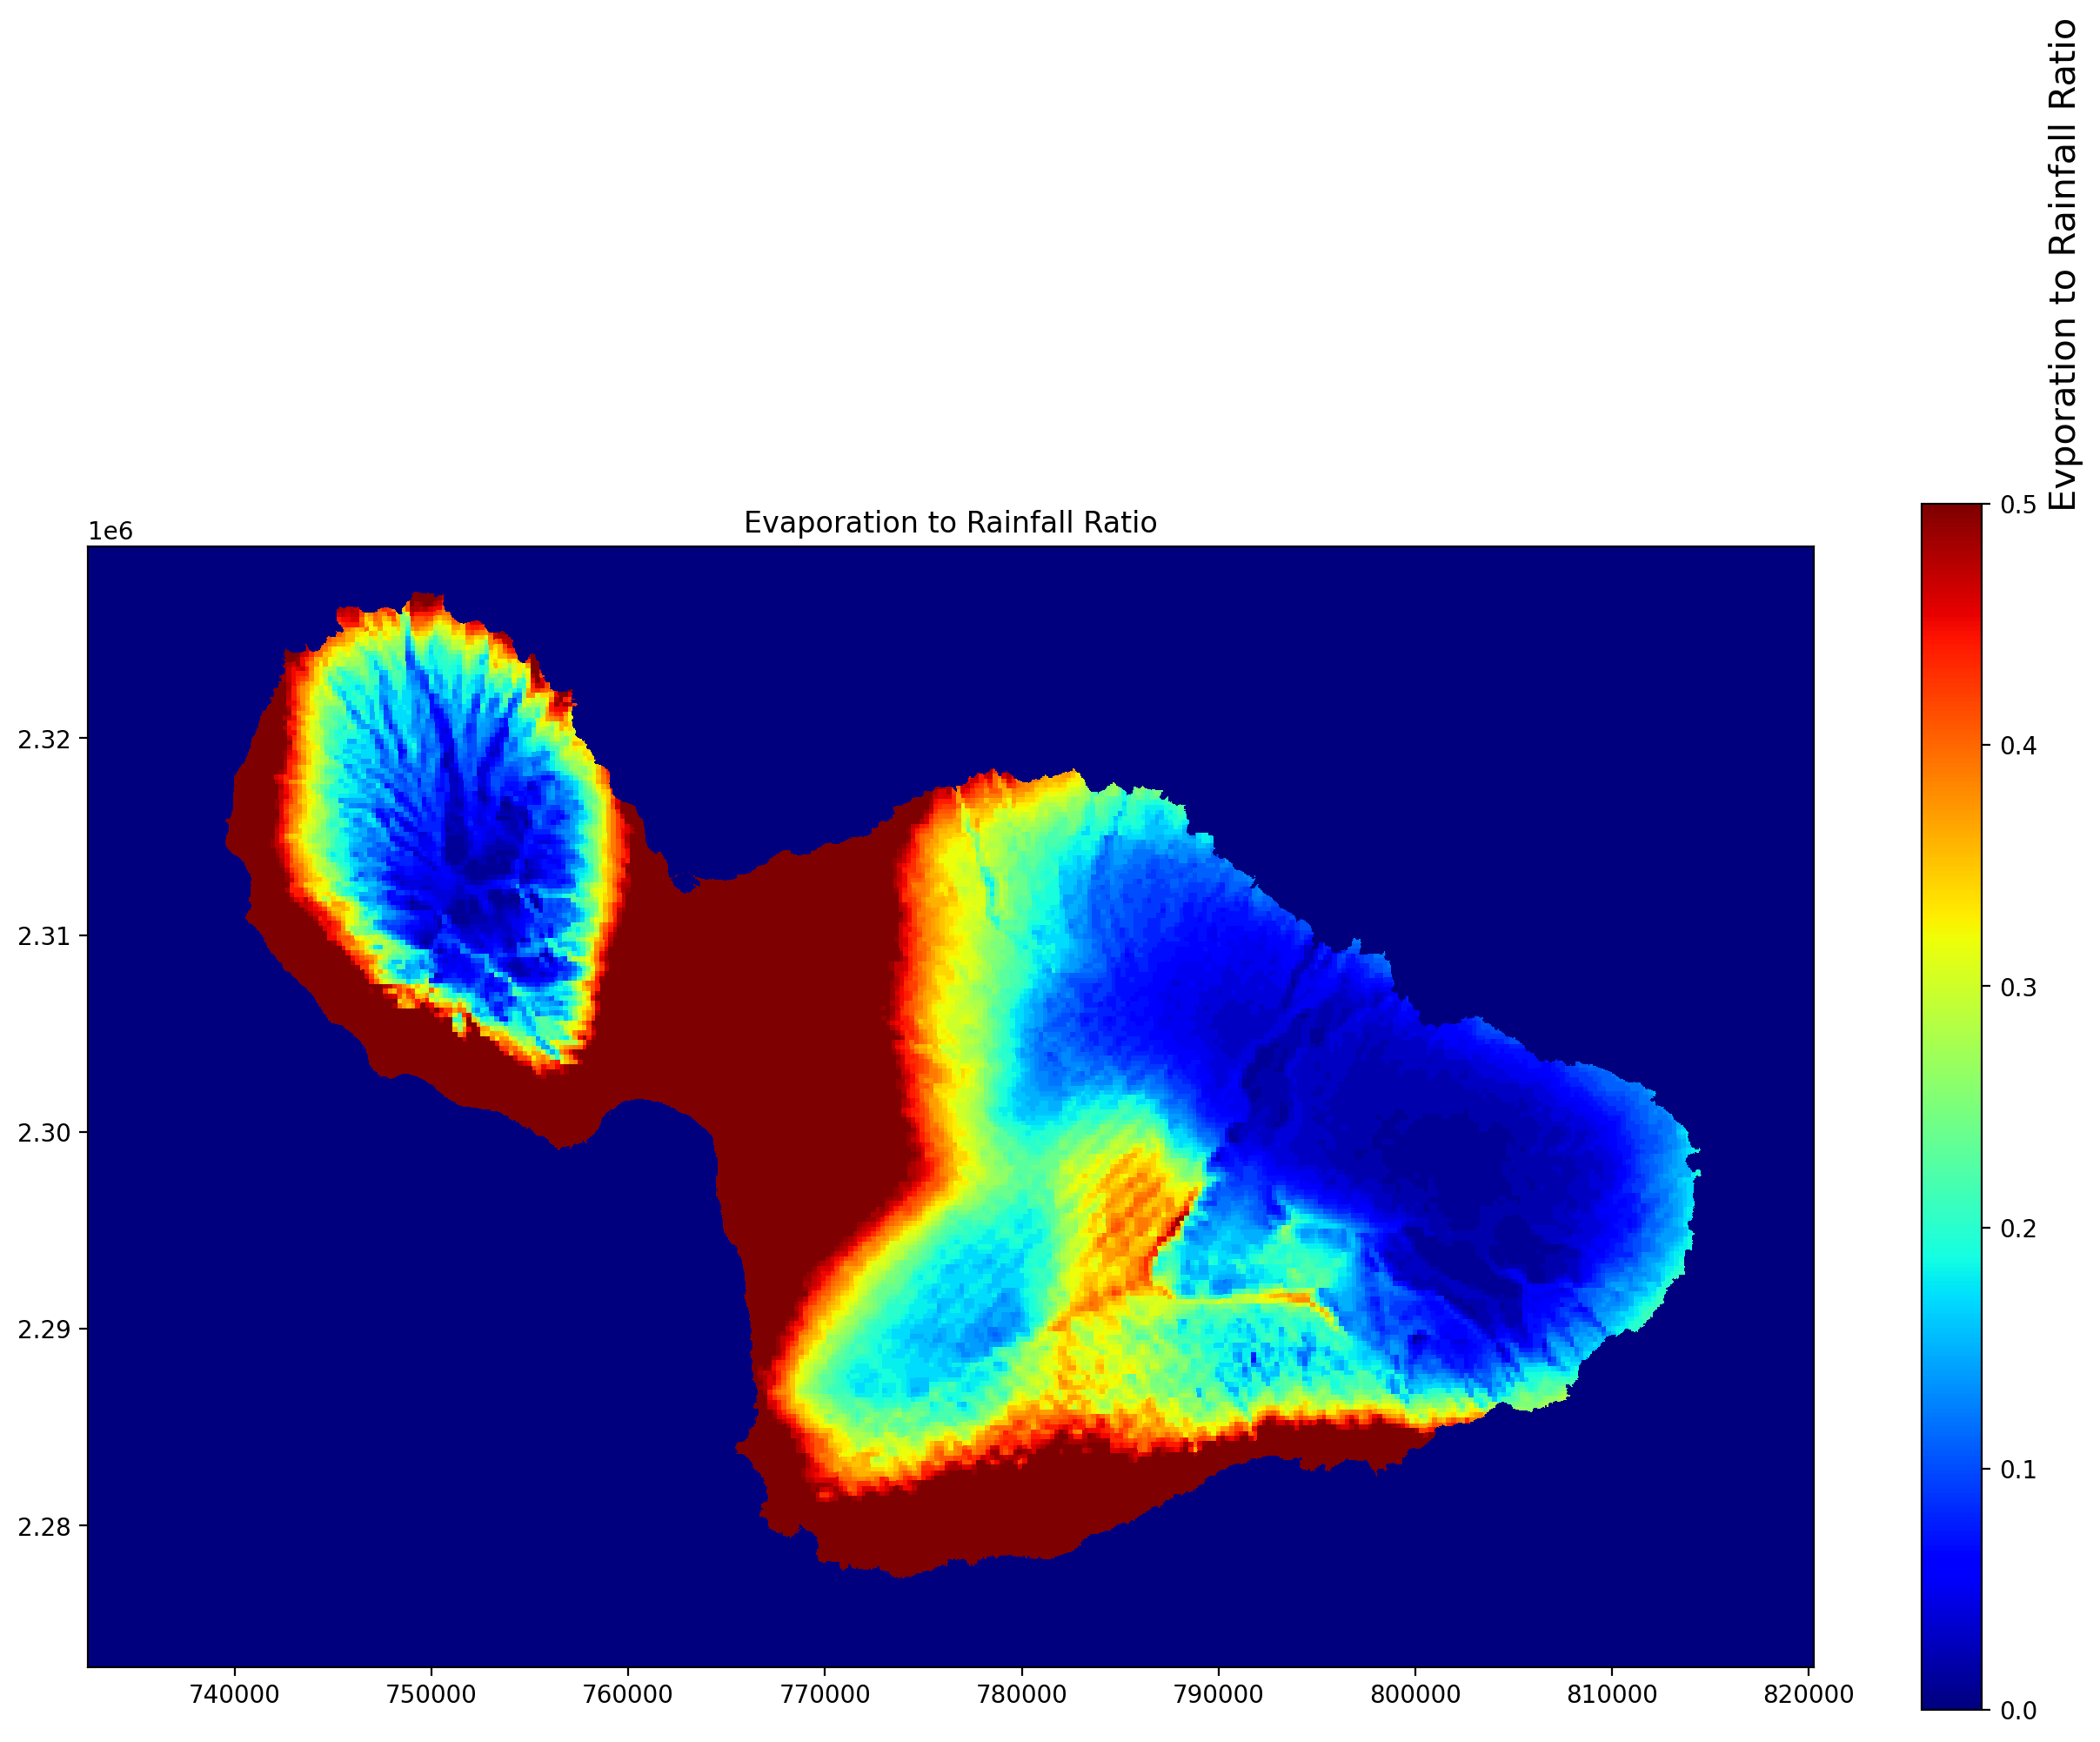

In [5]:
make_plot( x=er_xy[0], y=er_xy[1], var=er_data, discrete=False, title='Evaporation to Rainfall Ratio',
           barlabel='Evporation to Rainfall Ratio')

## Application

In the SWB version 2.0 code, $V$ (ratio of evaporation rate to rainfall rate) and $c$ (canopy fraction) are defined as gridded data sets, while , $p$ (stemflow fraction), $S$ (canopy storage) and $k$ (trunk storage capacity) are supplied as lookup table values by landuse.

## Control File Entries

In order to use a set of runoff ratios in SWB 2, the control file must be modified, specifically, by changing the method by which runoff is calculated:

```
INTERCEPTION_METHOD    GASH
```

Somewhere in the control file, the required gridfile and tabular data file must be specified. In the example control file, these entries are included in block 9:

```
FRACTION_CANOPY_COVER ARC_GRID input/maui_CANOPY_COVER_FRACTION__50m.asc
FRACTION_CANOPY_COVER_PROJECTION_DEFINITION +proj=utm +zone=4 +ellps=WGS84 +datum=WGS84 +units=m +no_defs

EVAPORATION_TO_RAINFALL_RATIO ARC_GRID input/maui_EVAPORATION_TO_RAINFALL_RATIO__50m.asc
EVAPORATION_TO_RAINFALL_RATIO_PROJECTION_DEFINITION +proj=utm +zone=4 +ellps=WGS84 +datum=WGS84 +units=m +no_defs
```

## Lookup Table Entries

Several of the Gash method parameters are supplied in one of the lookup tables, indexed by landuse code.

| Parameter Description                          | Lookup Table Column Name     |
|--------------------------------|-------------------------------
| Canopy storage capacity in inches    | Canopy_Storage_Capacity |
| Trunk storage capacity in inches     | Trunk_Storage_Capacity |
| Fraction of rainfall diverted to stemflow     | Stemflow_Fraction |